<a href="https://colab.research.google.com/github/Edwin1719/Robot_Trading/blob/main/Challenge_Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***PROYECTO ROBOT DE TRADING PARA BITCOIN***

<img src = "https://imageio.forbes.com/specials-images/imageserve/6409ebd45abeb7444ab50055/Digitized-Bitcoin-Symbol/960x0.jpg?format=jpg&width=960" width = "600"/>



### **1. Configuración del ambiente**

Importacion de las librerias que vamos a utilizar para el proyecto

In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

### **2. Obtención de los datos**

In [24]:
#Definiendo la funcion para la captura de datos en Yahoo Finance
def importar_base_bitcoin():
  global df_bitcoin

  #Obtenemos datos historicos del Bitcoin
  df_bitcoin = yf.download('BTC-USD', period= '7d', interval='5m')

In [25]:
importar_base_bitcoin()
df_bitcoin.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-04-04 00:00:00+00:00,65990.351562,65990.351562,65871.617188,65871.617188,65871.617188,0
2024-04-04 00:05:00+00:00,66014.601562,66084.695312,66014.601562,66084.695312,66084.695312,0
2024-04-04 00:10:00+00:00,66094.734375,66169.320312,66094.734375,66169.320312,66169.320312,16533504
2024-04-04 00:15:00+00:00,66193.742188,66226.375000,66181.093750,66186.992188,66186.992188,815104
2024-04-04 00:20:00+00:00,66157.671875,66298.679688,66157.671875,66272.695312,66272.695312,0


In [26]:
# Realizando el WebScraping para la pagina CoinMarketcap
from bs4 import BeautifulSoup
import requests

def extraer_tendencias():
    # Definición de variables globales dentro de la función
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

    # Solicitud GET a la página CoinMarketcap
    url = "https://coinmarketcap.com/"
    respuesta = requests.get(url)

    # Busqueda del contenido de la página web
    s = BeautifulSoup(respuesta.content, features='lxml')
    respuesta = s.findAll("p",{"class":"sc-4984dd93-0 iqdbQL coin-item-symbol"})

    indice =0
    for item in respuesta:
      if item.getText()== "BTC":
        break
      indice+=1

    # Identificando el precio actual en Tiempo real a partir de sus clases
    respuesta = s.findAll("div",{"class":["sc-500f568e-0 ejtlWy","sc-500f568e-0 ejtlWy fall","sc-500f568e-0 ejtlWy rise"]})
    precio_actual = float(respuesta[indice].getText().replace("$","").replace(",",""))

    # Identificando las clases de la tendencia para agregarlas a la lista vacia
    lista = []
    respuesta = s.findAll("span",{"class":["sc-6a54057-0 YXxPZ","sc-6a54057-0 iEhQde"]})
    for item in respuesta[::3]:
      lista.append(item)

    # Definiendo la tendencia con base en el icono de referencia
    tendencia = ""
    if lista[indice].find("span")["class"][0]== "icon-Caret-down":
      tendencia = "baja"
    else:
      tendencia = "alta"

In [27]:
extraer_tendencias()
print(f'Precio Actual: ${precio_actual} USD')
print(f'Tendencia: {tendencia}')

Precio Actual: $69383.96 USD
Tendencia: alta


### **3. Limpieza de los datos**


Exploracion de Datos sin Tratamiento

In [28]:
# Informacion del DataFrame y conteo de filas y columnas
print(df_bitcoin.info())
print(df_bitcoin.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1960 entries, 2024-04-04 00:00:00+00:00 to 2024-04-10 19:15:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1960 non-null   float64
 1   High       1960 non-null   float64
 2   Low        1960 non-null   float64
 3   Close      1960 non-null   float64
 4   Adj Close  1960 non-null   float64
 5   Volume     1960 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 107.2 KB
None
(1960, 6)


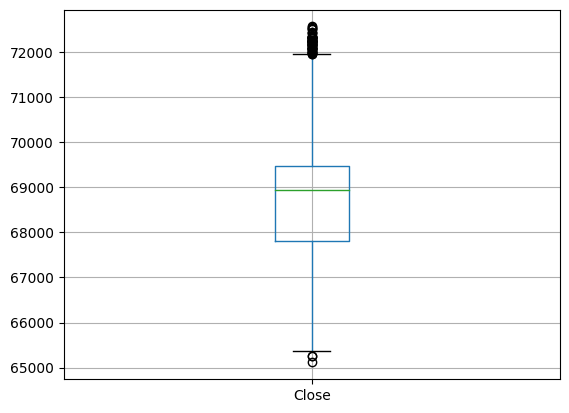

In [29]:
# Grafico Boxplot del DataFrame sin Tratamiento
df_bitcoin.boxplot('Close', showfliers=True);

Tratamiento y Limpieza de los Datos

In [30]:
# Creamos copia del Dataframe Bitcoin
global df_bitcoin_limpio
df_bitcoin.drop('Adj Close', axis =1, inplace=True)
df_bitcoin_limpio = df_bitcoin.copy()

In [31]:
# Creando de la Funcion de Limpieza del DataFrame
def limpieza_datos():
  global df_bitcoin, media_bitcoin, df_bitcoin_limpio

  #Creamos copia del dataframe original
  df_bitcoin_limpio = df_bitcoin.copy()

  # Identificación de índices duplicados
  indices_repetidos = df_bitcoin_limpio.duplicated().sum()

  # Eliminamos valores duplicados del dataframe en caso de existir
  df_bitcoin_limpio.drop_duplicates(inplace=True)

  # Chequeo de valores nulos en la columna "Close
  valores_nulos_close = 'Si' if df_bitcoin_limpio.Close.isna().any() == True else "No"

  # Tratamos los valores nulos de la columna close
  df_bitcoin_limpio.dropna(subset=['Close'], inplace=True)

  # Conteo de registros con Volume menor o igual a cero
  registros_cero = df_bitcoin_limpio.Volume[df_bitcoin_limpio.Volume <= 0].count()

  # Eliminamos registros que tengan un Volume de transaccion igual cero
  query = df_bitcoin_limpio.query('Volume <= 0').index
  df_bitcoin_limpio.drop(query, axis = 0, inplace = True)

  print(f'Existen {indices_repetidos} indices repetidos.')
  print(f'Existen valores nulos en la columna "Close": {valores_nulos_close}')
  print(f'Registros con Volumen de transacción menor o igual a cero: {registros_cero}')

  # Seleccionamos registro de la columna Close que esten entre Q1 y Q3
  Q1 = df_bitcoin_limpio.Close.quantile(0.25)
  Q3 = df_bitcoin_limpio.Close.quantile(0.75)

  # IIQ = Q3-Q1
  df_bitcoin_limpio = df_bitcoin_limpio.query(f'Close > {Q1} & Close < {Q3}')

  # Calculamos la media con los datos ya filtrados.
  media_bitcoin = round(df_bitcoin_limpio.Close.mean(),2)

  df_bitcoin

In [32]:
limpieza_datos()

Existen 0 indices repetidos.
Existen valores nulos en la columna "Close": No
Registros con Volumen de transacción menor o igual a cero: 977


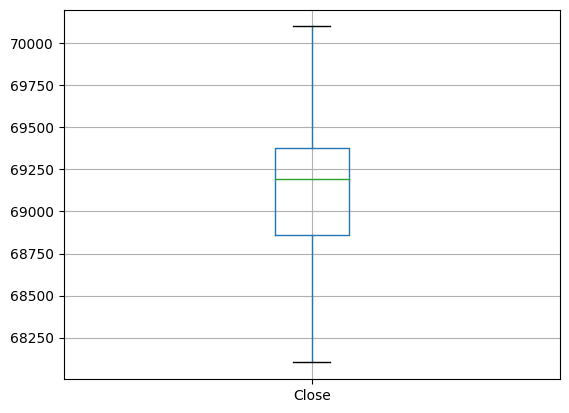

In [33]:
# Grafico Boxplot del DataFrame Limpio
df_bitcoin_limpio.boxplot('Close');

### **4. Tomar decisiones**

In [34]:
# Creando funcion para la toma de decision basado en los parametros dados
def tomar_decision():

  global algoritmo_decision, tendencia, media_bitcoin, precio_actual

  if precio_actual >= media_bitcoin and tendencia == 'Baja':
    algoritmo_decision = 'Vender'

  elif precio_actual < media_bitcoin and tendencia == 'Alta':
    algoritmo_decision = 'Comprar'

  else:
    algoritmo_decision = 'Esperar'

In [35]:
tomar_decision()
print(f"El Precio actual es de: {precio_actual}\nEl precio promedio es de:{media_bitcoin}\nLatendencia de una hora es:{tendencia}\nLa decision del programa es:{algoritmo_decision}")


El Precio actual es de: 69383.96
El precio promedio es de:69121.68
Latendencia de una hora es:alta
La decision del programa es:Esperar


### **5. Visualización**

In [52]:
# Creando funcion para visualizar los Datos
def visualizacion():
  global df_bitcoin, media_bitcoin, algoritmo_decision

  # Añadimos una nueva columna (Promedio)
  df_bitcoin['Promedio'] = media_bitcoin

  # Configuración del gráfico
  plt.figure(figsize=(16,5))
  plt.title('PRECIO BITCOIN ULTIMOS 7D $',fontsize=14,color="blue",backgroundcolor="lightgrey" )
  plt.plot(df_bitcoin.index, df_bitcoin.Close, linewidth = 0.85, color = 'black');
  plt.plot(df_bitcoin.index, df_bitcoin.Promedio, color = 'orange');
  plt.legend(['Precio Bitcoin', 'Promedio (7d)'])
  plt.grid(True)

  color = 'green' if algoritmo_decision == 'Vender' else 'blue' if algoritmo_decision == 'Comprar' else 'red'
  plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin.Close[-1]), xytext=(df_bitcoin.index[-1], df_bitcoin.Close[-1]-1500),
             arrowprops=dict(facecolor=color, shrink=.1, width = 5, headwidth = 10), horizontalalignment='center',fontsize=12)
  plt.show()

El Precio actual es de: 69383.96
El precio promedio es de:69121.68
Latendencia de una hora es:alta
La decision del programa es:Esperar


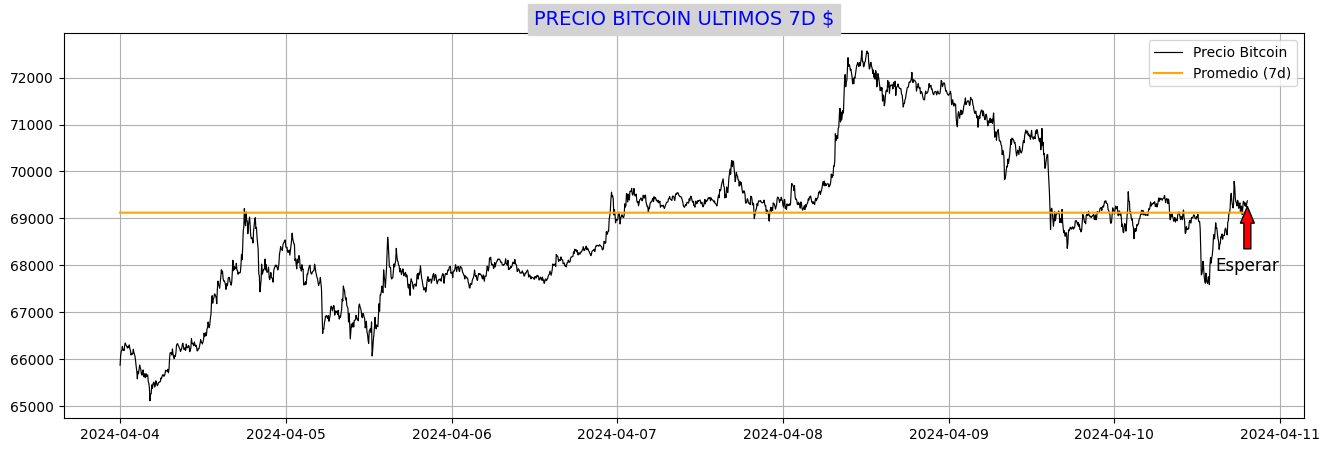

In [53]:
# Visializando los datos para la toma de decision
print(f"El Precio actual es de: {precio_actual}\nEl precio promedio es de:{media_bitcoin}\nLatendencia de una hora es:{tendencia}\nLa decision del programa es:{algoritmo_decision}")
visualizacion()

### **6. Automatización**

In [38]:
# Importamos librerias
from IPython.display import clear_output
import time

[*********************100%%**********************]  1 of 1 completed


Existen 0 indices repetidos.
Existen valores nulos en la columna "Close": No
Registros con Volumen de transacción menor o igual a cero: 977


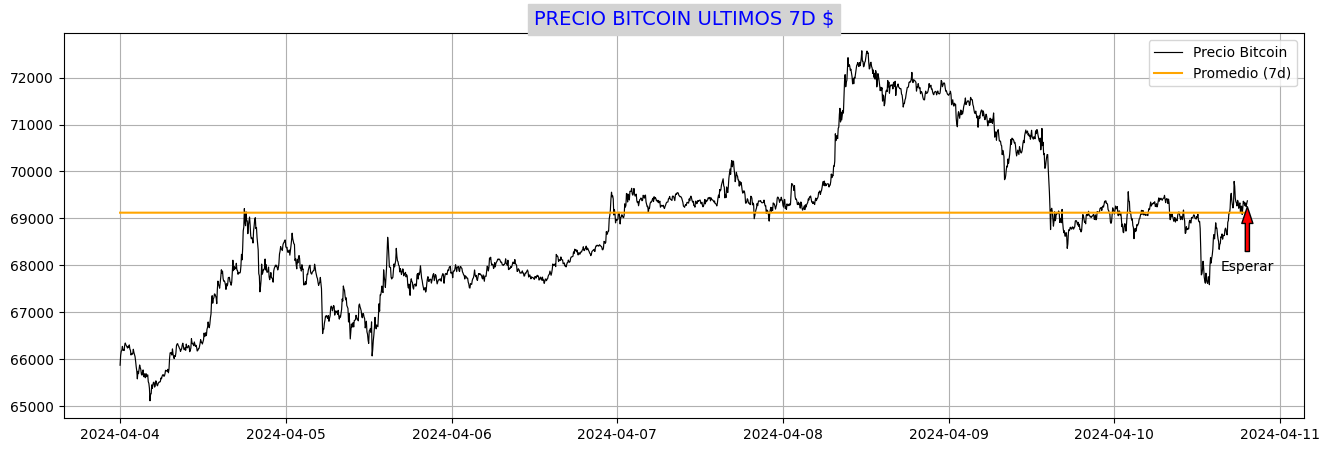

KeyboardInterrupt: 

In [39]:
# Bucle infinito

while(True):

  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decision()
  visualizacion()
  time.sleep(300)